<a href="https://colab.research.google.com/github/nye0/SAM-Med2D/blob/main/predictor_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SAM Comparison
This notebook contains a stripped down version of the predictor_example.ipynb file from the SAM repo as well as code to implement my model and thus verify that they perform identically.

In [2]:
# Change path to be one folder up to permit appropriate imports
import sys
import os
sys.path.insert(0, os.path.abspath('..'))

## Set-up

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


## Compare point-prompt based segmentations
### Use extracted code from predictor_example.ipynb to generate a segmentation

In [3]:
# Example image
image = cv2.imread('images/truck.jpg')

# First, load the SAM model and predictor.
from segment_anything import sam_model_registry, SamPredictor


sam_checkpoint = '/home/t722s/Desktop/UniversalModels/TrainedModels/sam_vit_h_4b8939.pth'
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

# Process the image to produce an image embedding by calling `SamPredictor.set_image`. `SamPredictor` remembers this embedding and will use it for subsequent mask prediction.
predictor.set_image(image)

# To select the truck, choose a point on it. Points are input to the model in (x,y) format and come with labels 1 (foreground point) or 0 (background point). Multiple points can be input; here we use only one. The chosen point will be shown as a star on the image.
input_point = np.array([[500, 375]])
input_label = np.array([1])

# Predict with `SamPredictor.predict`. The model returns masks, quality predictions for those masks, and low resolution mask logits that can be passed to the next iteration of prediction.
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=False,
)

In [4]:
from utils.testing import test_save, test_load
test_save(masks, 'masks')

### Now generate the same segmentation using code from this package

In [5]:
from utils.testing import test_save, test_load
masks = test_load('masks')

In [6]:
import numpy as np
import cv2
from classes.SAMClass import SAMInferer
from utils.base_classes import Points

# Load Model
device = 'cuda'
checkpoint_path = '/home/t722s/Desktop/UniversalModels/TrainedModels/sam_vit_h_4b8939.pth'
#inferer = SAMInferer(checkpoint_path, device)

# TESTING
from importlib import reload
import classes.SAMClass as c
reload(c)
inferer = c.SAMInferer(checkpoint_path, device)

# My model takes 3d grayscale images, so take the image, remove the color dimension and give it a z dimension
img_path = 'images/truck.jpg'
img_2d = cv2.imread(img_path)
img_3d = img_2d[:,:,0][None]

# Obtain same prompt as in demo
input_point = np.array([500, 375])
input_point_3d = np.concatenate([input_point, [0]]) # include a z dimension for the point
input_point_3d = input_point_3d[::-1] # Reverse order so xyz->zyx
input_point_3d = input_point_3d[None] # Give N dimension
input_label = np.array([1])

prompt = Points(coords = input_point_3d, labels = input_label)

# Segment
segmentation = inferer.predict(img_3d, prompt)

# Convert back to 2d to compare with original code and verify equality
seg_2d = segmentation[0] # Select slice for z=0

seg_original = masks[0] # Select first mask (only one mask returned in this case; look at comment)

arrays_equal = np.array_equal(seg_2d, seg_original)
print(f'Arrays equal? {arrays_equal}')
if not arrays_equal:
    print(f'Discrepancy: {np.count_nonzero(seg_2d!=seg_original)}')

Performing inference on slices: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]

Arrays equal? False
Discrepancy: 86877


Reason for discrepancy: SAM infers on images in color, while this package is for grayscale images. This significantly changes the input. Comparison of the segmentations generated indicates a pretty satisfactory demonstration of this package's code

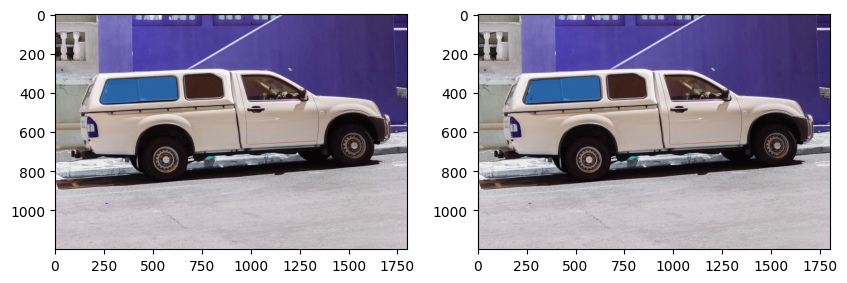

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5)) 

axes[0].imshow(img_2d, )
show_mask(seg_2d, axes[0])

axes[1].imshow(img_2d)
show_mask(seg_original, axes[1])

## Compare boxes
### From predictor_example.ipynb:

In [8]:
#The model can also take a box as input, provided in xyxy format.
input_box = np.array([425, 600, 700, 875])
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

In [10]:
from utils.testing import test_save, test_load
test_save(masks, 'masks')

## From this package:

In [1]:
from utils.testing import test_save, test_load
masks = test_load('masks')

ModuleNotFoundError: No module named 'utils'

In [7]:
from utils.base_classes import Boxes

# Obtain prompt
input_box = np.array([425, 600, 700, 875])
prompt = Boxes({0:input_box})

# Segment
segmentation = inferer.predict(img_3d, prompt)

## Convert back to 2d to compare with original code and verify equality
seg_2d = segmentation[0]
seg_original = masks[0]

print(f'Arrays equal? {np.array_equal(seg_2d, seg_original)}')
if not arrays_equal:
    print(f'Discrepancy: {np.count_nonzero(seg_2d!=seg_original)}')

Using previously generated image embeddings


Performing inference on slices: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]

Arrays equal? False
Discrepancy: 450


Same reason for discrepancy. Consider images

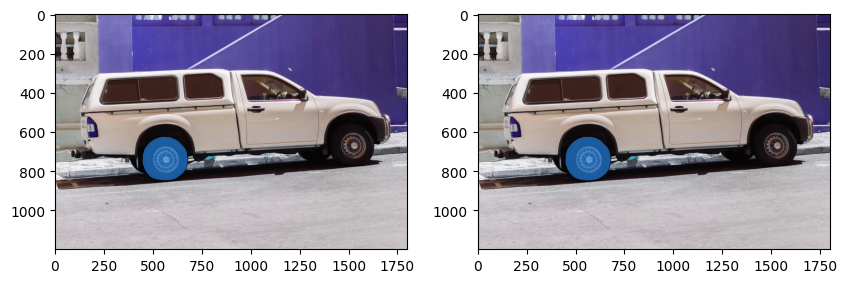

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5)) 

axes[0].imshow(img_2d, )
show_mask(seg_2d, axes[0])

axes[1].imshow(img_2d)
show_mask(seg_original, axes[1])